### CASE 1 Visualize the Experiment Result
Transfer the experiment result table to bar or line plots. The table includes the (model:explainer) performance on selected metrics, which are indicated by different colors in a bar/line plot, and their train/test times stacked in a bar plot.

In [1]:
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.metrics_explainer import (
    Metric_Exp_DIV as DIV,
    Metric_Exp_FPR as FPR,
)
from cornac.models import EFM, MTER
from cornac.models import ALS

from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.explainer import Exp_ALS as ALSExplainer


from cornac.visualization import Visualization
from cornac.utils import cache
from cornac.data import Reader
from cornac.eval_methods import RatioSplit
from cornac.data import SentimentModality
from cornac.datasets import movielens, amazon_toy

import warnings
warnings.filterwarnings("ignore")

/home/linan/miniconda3/envs/enaw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Initiate the instances of ```cornac.experiment.experiment_explainers```

In [2]:
rating = amazon_toy.load_feedback(fmt="UIRT", reader=Reader(min_user_freq=50))
sentiment_data = amazon_toy.load_sentiment(reader=Reader(min_user_freq=50))
md = SentimentModality(data=sentiment_data)

rs_sent_dense = RatioSplit(
    data=rating,
    test_size=0.2,
    sentiment=md,
    seed=42
)
ground_truth_good_reads = sentiment_data
fdiv = DIV()
fpr = FPR()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(
    max_iter=20,
    num_explicit_factors=50,
    num_latent_factors=50,
    num_most_cared_aspects=50,
    alpha=0.85,
    lambda_h=0.1,
    lambda_u=0.001,
    lambda_v=0.01,
    lambda_x=1.0,
    lambda_y=0.1,
)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)
mter = MTER(
    max_iter=20,
    n_aspect_factors=8,
    n_item_factors=5,
    n_opinion_factors=5,
    n_user_factors=10,
    lambda_bpr=10,
    lambda_reg=10,
    n_bpr_samples=1000,
    n_element_samples=50,
)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]
experiment_sent = Experiment_Explainers(
    eval_method=rs_sent_dense,
    models=models,
    metrics=metrics,
    rec_k=10,
    feature_k=10,
    eval_train=True,
)
experiment_sent.run()

INFO:cornac.experiment.experiment_explainers:Start training Recommender EFM...
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EFM creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_EFM create explanation for all recommendations
Computing explanations: 100%|██████████| 1190/1190 [00:00<00:00, 2349.10it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.6776614767009822
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_FPR starts evaluation...
Start evaluation... : 7964it [00:03, 2039.85it/s]                          
INFO:cornac.experiment.experiment_explainers:Result: Feature Precision: 0.8774098910310144; Feature Recall: 0.11218487543244209; Harmonic Mean: 0.19051583375353215
INFO

In [4]:
# Load MovieLens
data = movielens.load_feedback(variant="100K", reader=Reader(min_user_freq=150))

rs_dense = RatioSplit(
    data=data, test_size=0.2, exclude_unknowns=False, verbose=True
)

als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = ALSExplainer(rec_model=als, dataset=rs_dense.train_set)

fdiv = DIV()
models = [(als, als_exp)]
metrics = [fdiv]
experiment = Experiment_Explainers(
    eval_method=rs_dense,
    models=models,
    metrics=metrics,
    rec_k=10,
    feature_k=10,
    eval_train=True,
)
experiment.run()

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...


rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 230
Number of items = 1609
Number of ratings = 46456
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 230
Number of items = 1653
Number of ratings = 11615
Number of unknown users = 0
Number of unknown items = 44
---
Total users = 230
Total items = 1653


100%|██████████| 500/500 [00:10<00:00, 47.24it/s, loss=0.101]
INFO:implicit:Final training loss 0.1006
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 2300/2300 [00:40<00:00, 56.84it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.036957996860748896
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.036957996860748896, 10.614705801010132, 47.705174922943115]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.036957996860

##### Plot result
Pass the experiment instances as a list to ```Visualization.visualize_experiment_result```

Plot the bar chart for the metrics:


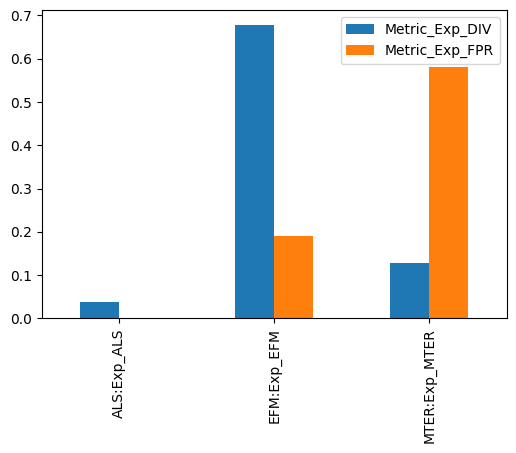

               Metric_Exp_DIV  Metric_Exp_FPR
ALS:Exp_ALS          0.036958        0.000000
EFM:Exp_EFM          0.677661        0.190516
MTER:Exp_MTER        0.127545        0.581572
Plot the bar chart for the cost:


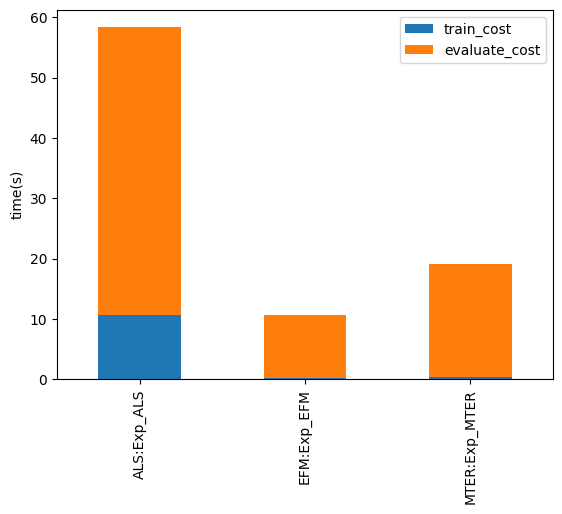

In [5]:
vis = Visualization()
vis.visualize_experiment_result([experiment, experiment_sent], kind="bar")

### CASE 2 Visualize the Effect of Parameters' Change (rec_k, feature_k)

##### 2.1 Metrics FDIV&FPR on EFM and MTER vs feature_k

In [1]:
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.metrics_explainer import (
    Metric_Exp_DIV as DIV,
    Metric_Exp_FPR as FPR,
)
from cornac.models import EFM, MTER
from cornac.explainer import Exp_EFM, Exp_MTER

from cornac.eval_methods import RatioSplit
from cornac.datasets import amazon_toy
from cornac.data import Reader
from cornac.visualization import Visualization
from cornac.data import SentimentModality

import warnings
warnings.filterwarnings("ignore")

/home/linan/miniconda3/envs/enaw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Generate instances of ```cornac.experiment.experiment_explainers``` for different feature_k/rec_k values

In [2]:
rating = amazon_toy.load_feedback(fmt="UIRT", reader=Reader(min_user_freq=50))
sentiment_data = amazon_toy.load_sentiment(reader=Reader(min_user_freq=50))

md = SentimentModality(data=sentiment_data)
rs_sent_dense = RatioSplit(
    data=rating,
    test_size=0.2,
    sentiment=md,
    seed=42
)
ground_truth_good_reads = sentiment_data

fdiv = DIV()
fpr = FPR()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(
    max_iter=20,
    num_explicit_factors=50,
    num_latent_factors=50,
    num_most_cared_aspects=50,
    alpha=0.85,
    lambda_h=0.1,
    lambda_u=0.001,
    lambda_v=0.01,
    lambda_x=1.0,
    lambda_y=0.1,
)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)

mter = MTER(
    max_iter=20,
    n_aspect_factors=8,
    n_item_factors=5,
    n_opinion_factors=5,
    n_user_factors=10,
    lambda_bpr=10,
    lambda_reg=10,
    n_bpr_samples=1000,
    n_element_samples=50,
)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]

### To visualize the effect of increasing the number of features, we can run the experiment for different values of feature_k
EE_list = []
feature_k_list = [i for i in range(5, 11)]

for feature_k in feature_k_list:
    experiment_sent = Experiment_Explainers(
        eval_method=rs_sent_dense,
        models=models,
        metrics=metrics,
        rec_k=10,
        feature_k=feature_k,
        eval_train=True,
    )
    experiment_sent.run()
    EE_list.append(experiment_sent)

INFO:cornac.experiment.experiment_explainers:Start training Recommender EFM...
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EFM creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_EFM create explanation for all recommendations
Computing explanations: 100%|██████████| 1190/1190 [00:00<00:00, 1230.87it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.47849686552563025
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_FPR starts evaluation...
Start evaluation... : 7964it [00:04, 1964.84it/s]                          
INFO:cornac.experiment.experiment_explainers:Result: Feature Precision: 0.8604469273743017; Feature Recall: 0.10894429365778054; Harmonic Mean: 0.18537998469766762
INF

##### Line Plot Example
Pass the experiment instances as a list to visualization

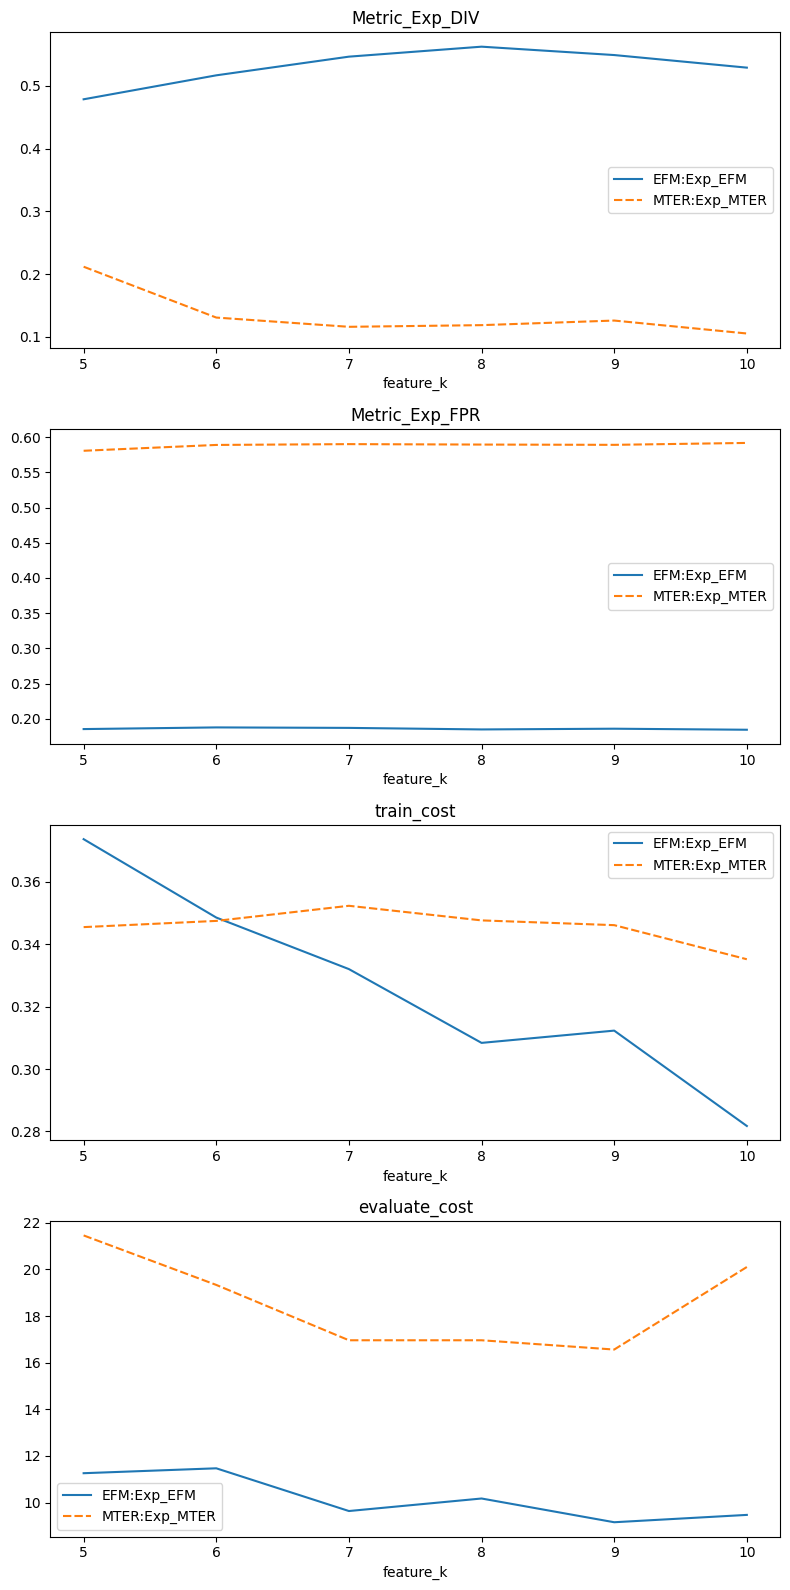

In [3]:
vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="feature_k", kind="line")

##### 2.2 Metrics FDIV on the MF models & explainers vs feature_k

In [4]:
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.models import EMF, NEMF, ALS
from cornac.explainer import Exp_ALS, Exp_SU4EMF
from cornac.metrics_explainer import Metric_Exp_DIV as DIV
from cornac.data import Reader

import warnings
warnings.filterwarnings("ignore")


# Load MovieLens
data = movielens.load_feedback(variant="100K", reader=Reader(min_user_freq=150))

# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=data, test_size=0.2, exclude_unknowns=False, verbose=True
)

emf = EMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
nemf = NEMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    novel_reg=1,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = Exp_ALS(rec_model=als, dataset=ratio_split.train_set)
emf_exp = Exp_SU4EMF(rec_model=emf, dataset=ratio_split.train_set)
nemf_exp = Exp_SU4EMF(rec_model=nemf, dataset=ratio_split.train_set)
fdiv = DIV()
models = [(als, als_exp), (emf, emf_exp), (nemf, nemf_exp)]
metrics = [fdiv]

# feature_k_list = [i for i in range(5, 11)]
rec_k_list = [i for i in range(5, 11)]
EE_list = []
for rec_k in rec_k_list:
    print(f"\nCurrent loop: Processing rec_k = {rec_k}")
    experiment = Experiment_Explainers(
        eval_method=ratio_split,
        models=models,
        metrics=metrics,
        rec_k=rec_k,
        feature_k=10,
        eval_train=True,
    )
    experiment.run()
    EE_list.append(experiment)

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...


rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 230
Number of items = 1618
Number of ratings = 46456
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 230
Number of items = 1653
Number of ratings = 11615
Number of unknown users = 0
Number of unknown items = 35
---
Total users = 230
Total items = 1653

Current loop: Processing rec_k = 5


100%|██████████| 500/500 [00:10<00:00, 47.32it/s, loss=0.1] 
INFO:implicit:Final training loss 0.1003
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 1150/1150 [00:21<00:00, 52.77it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.03296219775229162
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:01<00:00, 282.68it/s, loss=16286.68]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF 

Optimization finished!


Computing explanations: 100%|██████████| 1150/1150 [00:02<00:00, 551.56it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5730396656826576
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


 97%|█████████▋| 484/500 [00:01<00:00, 265.60it/s, loss=22785.40]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 1150/1150 [00:01<00:00, 596.19it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.23841807909604437
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.03296219775229162, 10.57249641418457, 23.774648904800415], [0.5730396656826576, 2.1787917613983154, 2.8893659114837646], [0.23841807909604437, 2.401247262954712, 2.129617214202881]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |      Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.03296219775229162 |  10.57249641418457 | 23.774648904800415
EMF:Exp_SU4EMF        |  0.5730396656826576 | 2.1787917613983154 | 2.8893659114837646
NEMF:Exp_SU4EMF       | 0.23841807909604437 |  2.401247262954712 |  2.129617214202881

INFO:cornac.experiment.experiment_explainers:Start training Recommender AL


Current loop: Processing rec_k = 6


100%|██████████| 500/500 [00:10<00:00, 48.59it/s, loss=0.1] 
INFO:implicit:Final training loss 0.1003
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 1380/1380 [00:20<00:00, 66.06it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.03326302403542882
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:01<00:00, 326.43it/s, loss=16305.12]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF 

Optimization finished!


Computing explanations: 100%|██████████| 1380/1380 [00:02<00:00, 586.62it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5669010569367359
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


100%|██████████| 500/500 [00:02<00:00, 242.15it/s, loss=22775.83]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations: 100%|██████████| 1380/1380 [00:02<00:00, 596.28it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.2383093286650246
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.03326302403542882, 10.293623208999634, 23.38054609298706], [0.5669010569367359, 1.926677942276001, 3.095841407775879], [0.2383093286650246, 2.6721267700195312, 2.547149896621704]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |      Metric_Exp_DIV |           Train(s) |       Evaluate(s)
ALS:Exp_ALS           | 0.03326302403542882 | 10.293623208999634 | 23.38054609298706
EMF:Exp_SU4EMF        |  0.5669010569367359 |  1.926677942276001 | 3.095841407775879
NEMF:Exp_SU4EMF       |  0.2383093286650246 | 2.6721267700195312 | 2.547149896621704

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...



Current loop: Processing rec_k = 7


100%|██████████| 500/500 [00:10<00:00, 49.55it/s, loss=0.1] 
INFO:implicit:Final training loss 0.1003
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 1610/1610 [00:29<00:00, 53.89it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.033648151507909924
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:02<00:00, 236.43it/s, loss=16313.83]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF

Optimization finished!


Computing explanations: 100%|██████████| 1610/1610 [00:02<00:00, 537.48it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5753619429651939
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


 20%|██        | 100/500 [00:00<00:02, 156.28it/s, loss=22774.69]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 1610/1610 [00:02<00:00, 558.41it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.2491195201475572
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.033648151507909924, 10.093474388122559, 33.155766010284424], [0.5753619429651939, 2.5308525562286377, 3.7089450359344482], [0.2491195201475572, 1.303079605102539, 3.2190370559692383]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.033648151507909924 | 10.093474388122559 | 33.155766010284424
EMF:Exp_SU4EMF        |   0.5753619429651939 | 2.5308525562286377 | 3.7089450359344482
NEMF:Exp_SU4EMF       |   0.2491195201475572 |  1.303079605102539 | 3.2190370559692383

INFO:cornac.experiment.experiment_explainers:Start training Recommend


Current loop: Processing rec_k = 8


100%|██████████| 500/500 [00:10<00:00, 47.63it/s, loss=0.1] 
INFO:implicit:Final training loss 0.1003
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 1840/1840 [00:33<00:00, 55.35it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.03387427004264902
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:02<00:00, 240.99it/s, loss=16303.57]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF 

Optimization finished!


Computing explanations: 100%|██████████| 1840/1840 [00:03<00:00, 544.30it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5800143471860937
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


 49%|████▊     | 243/500 [00:01<00:01, 160.90it/s, loss=22771.84]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 1840/1840 [00:03<00:00, 550.19it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.2450952907094958
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.03387427004264902, 10.501093626022339, 37.8493390083313], [0.5800143471860937, 2.5064759254455566, 4.1301515102386475], [0.2450952907094958, 2.2259092330932617, 3.7567412853240967]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |      Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.03387427004264902 | 10.501093626022339 |   37.8493390083313
EMF:Exp_SU4EMF        |  0.5800143471860937 | 2.5064759254455566 | 4.1301515102386475
NEMF:Exp_SU4EMF       |  0.2450952907094958 | 2.2259092330932617 | 3.7567412853240967

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS


Current loop: Processing rec_k = 9


100%|██████████| 500/500 [00:10<00:00, 46.59it/s, loss=0.1] 
INFO:implicit:Final training loss 0.1003
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 2070/2070 [00:37<00:00, 54.96it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.03414279810304466
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
 93%|█████████▎| 464/500 [00:01<00:00, 236.96it/s, loss=16264.00]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF 

Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 2070/2070 [00:03<00:00, 544.09it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5573128986508271
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  9%|▉         | 45/500 [00:00<00:02, 169.84it/s, loss=22771.98]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 2070/2070 [00:03<00:00, 545.08it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.24684162493614142
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.03414279810304466, 10.736149787902832, 43.241230487823486], [0.5573128986508271, 2.380613088607788, 4.704944849014282], [0.24684162493614142, 0.9533419609069824, 4.3229286670684814]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |      Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.03414279810304466 | 10.736149787902832 | 43.241230487823486
EMF:Exp_SU4EMF        |  0.5573128986508271 |  2.380613088607788 |  4.704944849014282
NEMF:Exp_SU4EMF       | 0.24684162493614142 | 0.9533419609069824 | 4.3229286670684814

INFO:cornac.experiment.experiment_explainers:Start training Recommender A


Current loop: Processing rec_k = 10


100%|██████████| 500/500 [00:10<00:00, 47.87it/s, loss=0.1] 
INFO:implicit:Final training loss 0.1003
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 2300/2300 [00:39<00:00, 58.40it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.033972993929359485
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:01<00:00, 266.44it/s, loss=16284.58]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF

Optimization finished!


Computing explanations: 100%|██████████| 2300/2300 [00:04<00:00, 547.18it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5531909424605558
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  3%|▎         | 17/500 [00:00<00:02, 189.67it/s, loss=22771.54]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 2300/2300 [00:04<00:00, 554.26it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.24989203771599292
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.033972993929359485, 10.447792291641235, 46.153321743011475], [0.5531909424605558, 2.301156997680664, 5.210463762283325], [0.24989203771599292, 0.7545201778411865, 4.655560493469238]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.033972993929359485 | 10.447792291641235 | 46.153321743011475
EMF:Exp_SU4EMF        |   0.5531909424605558 |  2.301156997680664 |  5.210463762283325
NEMF:Exp_SU4EMF       |  0.24989203771599292 | 0.7545201778411865 |  4.655560493469238



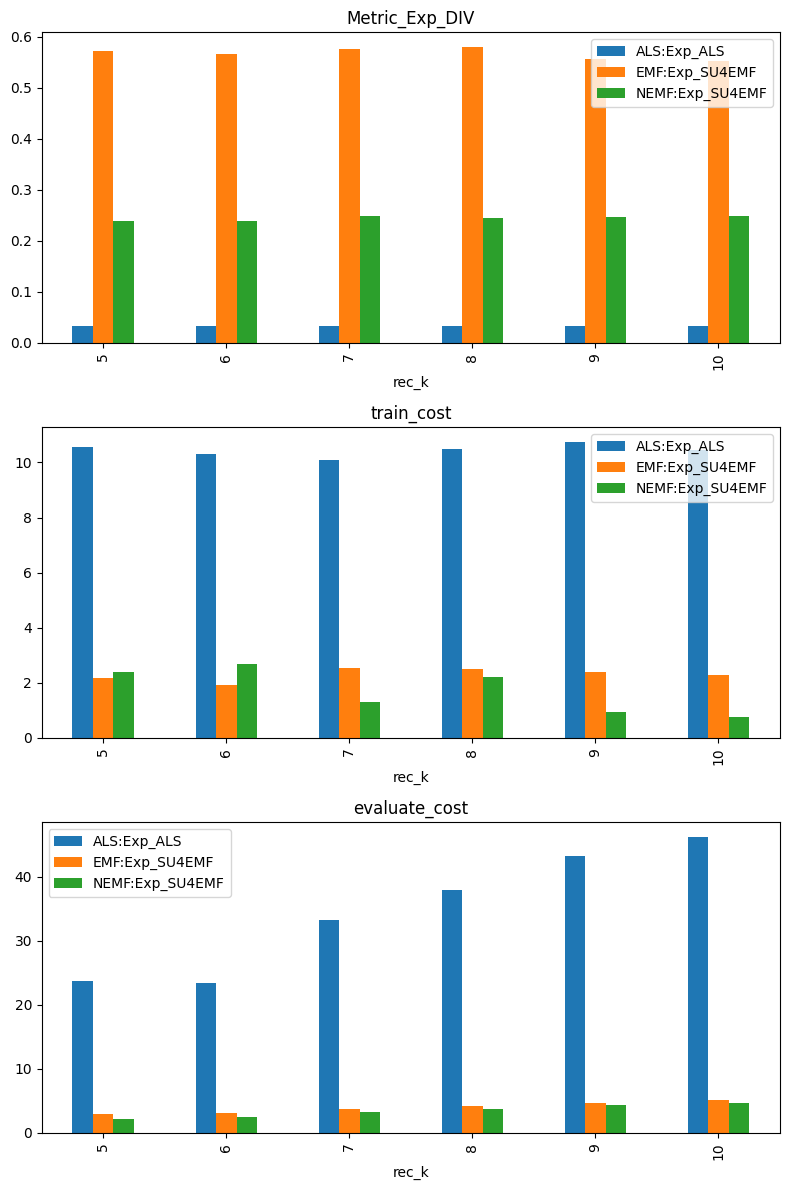

In [5]:
from cornac.visualization import Visualization

vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="rec_k", kind="bar")

### CASE 3 Visualize feature importance

The visualization function can be called for a specific user and item, or an item, or a user, or all users

In [2]:
import numpy as np
from cornac.models.fm_py import FMRec
from cornac.explainer.exp_limers import Exp_LIMERS
import warnings

warnings.filterwarnings("ignore")
from cornac.datasets import amazon_toy
import numpy as np
from cornac.data import FeatureModality
from cornac.eval_methods import RatioSplit


def create_item_features_from_aspects(at_sentiment):
    """Separate aspects and opinions from sentiment data and create item and user features from them."""
    items = {}
    users = {}
    for _, row in enumerate(at_sentiment):
        user, item, sentiments = row
        if user not in users:
            users[user] = []
        if item not in items:
            items[item] = []
        for sentiment in sentiments:
            if sentiment[0] not in items[item]:
                items[item].append(sentiment[0])  # aspect adds to item feature
            if sentiment[1] not in users[user]:
                users[user].append(sentiment[1])  # opinion adds to user feature

    item_aspect_pairs = np.array(
        [(item, feature) for item in items for feature in items[item]]
    )
    user_opinion_pairs = np.array(
        [(user, feature) for user in users for feature in users[user]]
    )
    return item_aspect_pairs, user_opinion_pairs, items.keys(), users.keys()


at_feedback = amazon_toy.load_feedback()
at_feedback = at_feedback[: len(at_feedback) // 20]  # reduce data size
at_sentiment = amazon_toy.load_sentiment()
items_feature, users_feature, items_list, users_list = (
    create_item_features_from_aspects(at_sentiment)
)
# remove unknown users and items from rating data
at_feedback_excl_unknowns = [
    x for x in at_feedback if x[0] in users_list and x[1] in items_list
]
rs = RatioSplit(
    data=at_feedback,
    test_size=0.2,
    item_feature=FeatureModality(items_feature),
    # user_feature=FeatureModality(users_feature), # user feature is not used in this experiment
    seed=42,
    exclude_unknowns=True,
)


fm = FMRec()
fm.fit(train_set=rs.train_set)

explainer = Exp_LIMERS(rec_model=fm, dataset=rs.train_set)
users = np.array(list(rs.train_set.uid_map.keys()))
items = np.array(list(rs.train_set.iid_map.keys()))
recommendations = fm.recommend_to_multiple_users(users, k=10)
explanations = explainer.explain_recommendations(recommendations, feature_k=6)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.84335
-- Epoch 2
Training MSE: 0.54054
-- Epoch 3
Training MSE: 0.47963
-- Epoch 4
Training MSE: 0.43793
-- Epoch 5
Training MSE: 0.40798
-- Epoch 6
Training MSE: 0.38155
-- Epoch 7
Training MSE: 0.36740
-- Epoch 8
Training MSE: 0.35302
-- Epoch 9
Training MSE: 0.34088
-- Epoch 10
Training MSE: 0.33139


Computing explanations: 100%|██████████| 46680/46680 [38:36<00:00, 20.15it/s]


In [3]:
from cornac.experiment.visualization import Visualization

explanations_df = explanations.copy()
my_plots = Visualization()

# Create a plot for a specific user and item
ind_df = my_plots.create_individual_feature_importance_plot(
    explanations,
    user_id="A4P2P0GAMR7XX",
    item_id="B00004T2XP",
    type="bar",
    top_k=6,
    save_plot=False,
)

In [4]:
# Create a plot for a specific item
filtered_df1 = my_plots.create_aggregate_feature_importance_plot(
    explanations, item_id="B00004T2XP", type="scatter", top_k=8, save_plot=False
)

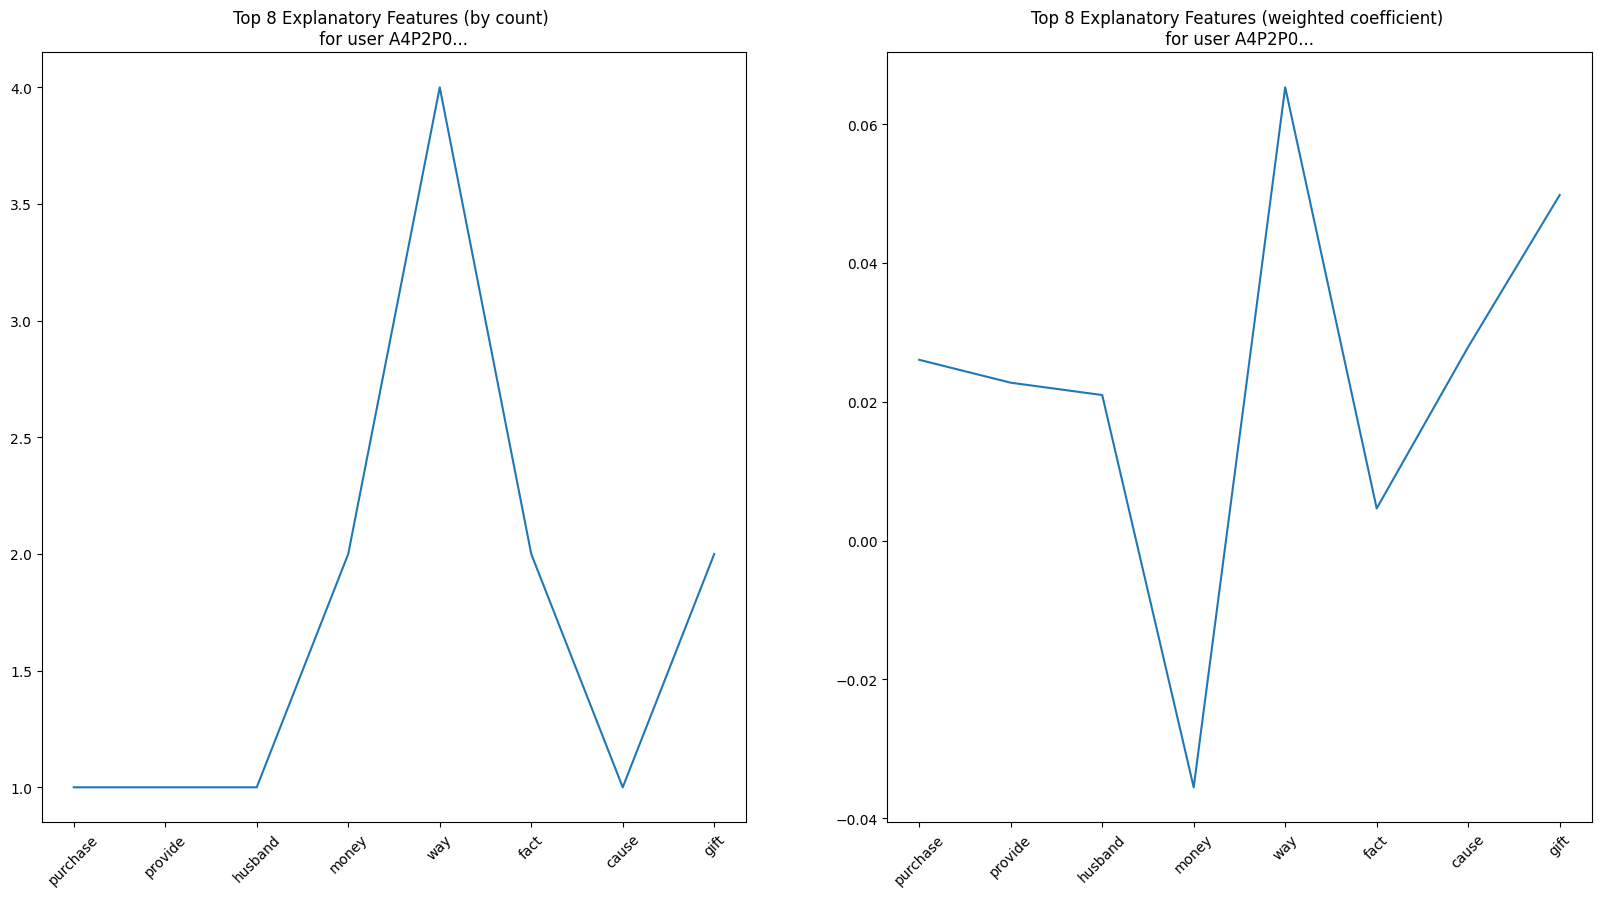

In [5]:
# Create a plot for a specific user
filtered_df2 = my_plots.create_aggregate_feature_importance_plot(
    explanations,
    user_id="A4P2P0GAMR7XX",
    type="line",
    top_k=8,
    save_plot=False,
)

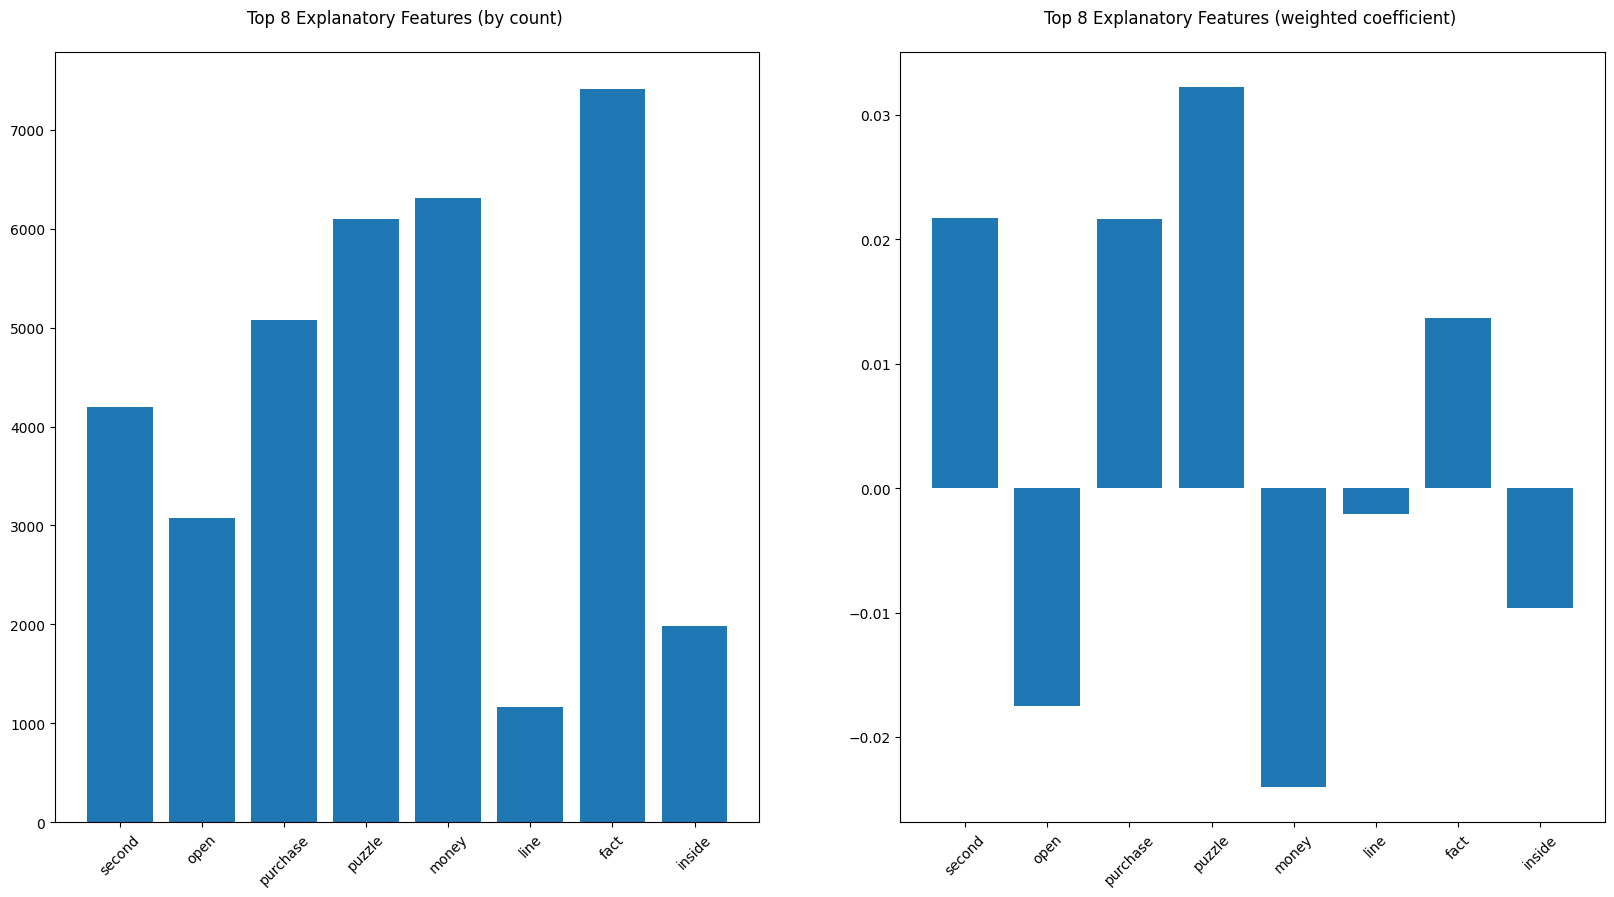

In [6]:
# Create a plot for all users
filtered_df3 = my_plots.create_aggregate_feature_importance_plot(
    explanations, type="bar", top_k=8, save_plot=False
)